此為深度學習之影像分割的練習，使用的資料集為左右頸部的超音波圖片，目標是從影像中分割出頸動脈

我使用了UNet去進行訓練，並使用Dice分數來當衡量標準，最後打印一些圖出來去驗證模型是否能準確的分割影像，超參數的部分在def get_args()中可以找到。

In [1]:
# The goal is to segment the carotid artery from the image, which is a typical semantic segmentation problem.

import numpy as np 
import pandas as pd 

# For network processing
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import argparse

# For system operation
import os
import io
import random
import datetime
import time
import glob
from tqdm import tqdm

# For image processing
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# For data augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import *

# For data processing
import wandb
from collections import defaultdict, deque

!pip install -q torchprofile
from torchprofile import profile_macs
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/mia-hw4/sono/sample_submission.csv
/kaggle/input/mia-hw4/sono/train.csv
/kaggle/input/mia-hw4/sono/test.csv
/kaggle/input/mia-hw4/sono/test/pre/frame394.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame378.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame384.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame329.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame358.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame360.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame351.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame350.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame316.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame353.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame391.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame313.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame345.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame333.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame303.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame396.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame395.bmp
/kaggle/input/mia-hw4/sono/test/pre/frame312.

In [2]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def print_with_timestamp():
    """
    This function add timestamp to each log info
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        timestamp = datetime.datetime.now().strftime("[%H:%M:%S]")
        args = (f"{timestamp} ",) + args
        builtin_print(*args, **kwargs)

    __builtin__.print = print

# Run Length Encoding

In [3]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
        fg_val: Value representing the foreground in the input array (default is 1)
    Returns: run length encoding as list
    """
    # Find indices where the array is equal to the foreground value
    dots = np.where(x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    
    run_lengths = []
    prev = -2
    for b in dots:
        # If the index is not consecutive, start a new run
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1  # Increment the length of the current run
        prev = b

    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x:  # Check if the list is non-empty
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

def rle_decode(mask_rle, shape=(566, 640)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    # Initialize an array of zeros with the specified shape
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    # Check if the mask_rle is empty
    if mask_rle != '-': 
        s = mask_rle.split()
        # Extract start and length information from the string
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1  # Convert to 0-based indexing
        ends = starts + lengths
        
        # Set the corresponding indices to 1 in the array
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1

    # Reshape the array to the specified shape and return
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

In [4]:
class WandbLogger(object):
    
    def __init__(self, config):
        
        self.config = config
        self._wandb =  wandb
        
    def login(self, key):
        self._wandb.login(key=key, relogin=True)
        
    def init_run(self):
        self.mask_table = wandb.Table(columns=["Images", "Masks", "Probs", "Preds", "Fusion", "IoU"], allow_mixed_types=True)
        self._wandb.init(
            config=self.config,
            project=self.config["project"],
            entity=self.config["entity"],
            name=self.config["name"],
            reinit=True
        )

    def log_checkpoints(self):
        output_dir = self.config["output_dir"]
        model_artifact = self._wandb.Artifact(
            self._wandb.run.id + "_model", type="model"
        )

        model_artifact.add_dir(output_dir)
        self._wandb.log_artifact(model_artifact, aliases=["latest", "best"])
        
    def log_image(self, images, masks, probs, binary_mask_threshold, fusion, iou):
        self.mask_table.add_data(
            wandb.Image(images),
            wandb.Image(masks),
            wandb.Image(probs),
            wandb.Image(binary_mask_threshold),
            wandb.Image(fusion),
            iou
        )

In [5]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{value:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

In [6]:
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))

# Dataset

In [7]:
def build_transform(is_train, args):
    """
    Create a data transformation pipeline for image processing in deep learning tasks.
    """
    t = []
    if is_train:
        t.append(A.Resize(args.input_size[-2], args.input_size[-1]))
        
        # t.append(A.HorizontalFlip(p=0.5))  # 50%的進行水平轉
        
        t.append(A.Normalize(args.mean, args.std))
        t.append(ToTensorV2())
        return A.Compose(t)

    t.append(A.Resize(args.input_size[-2], args.input_size[-1]))
    t.append(A.Normalize(args.mean, args.std))
    t.append(ToTensorV2())
    return A.Compose(t)

In [8]:
class DeepMedical(torch.utils.data.Dataset):
    def __init__(self, images, transforms = None):
        self.transforms = transforms   
        
        self.image_paths = images
        self.mask_paths = [image.replace('pre', 'post') + '_ROI.bmp' for image in images]

        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = np.array(Image.open(image_path).convert('RGB'))
        mask = np.array(Image.open(mask_path)) * 1

        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
            
        return image, mask
    
class SonoDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

Image shape: torch.Size([16, 3, 448, 448]), mask shape torch.Size([448, 448])


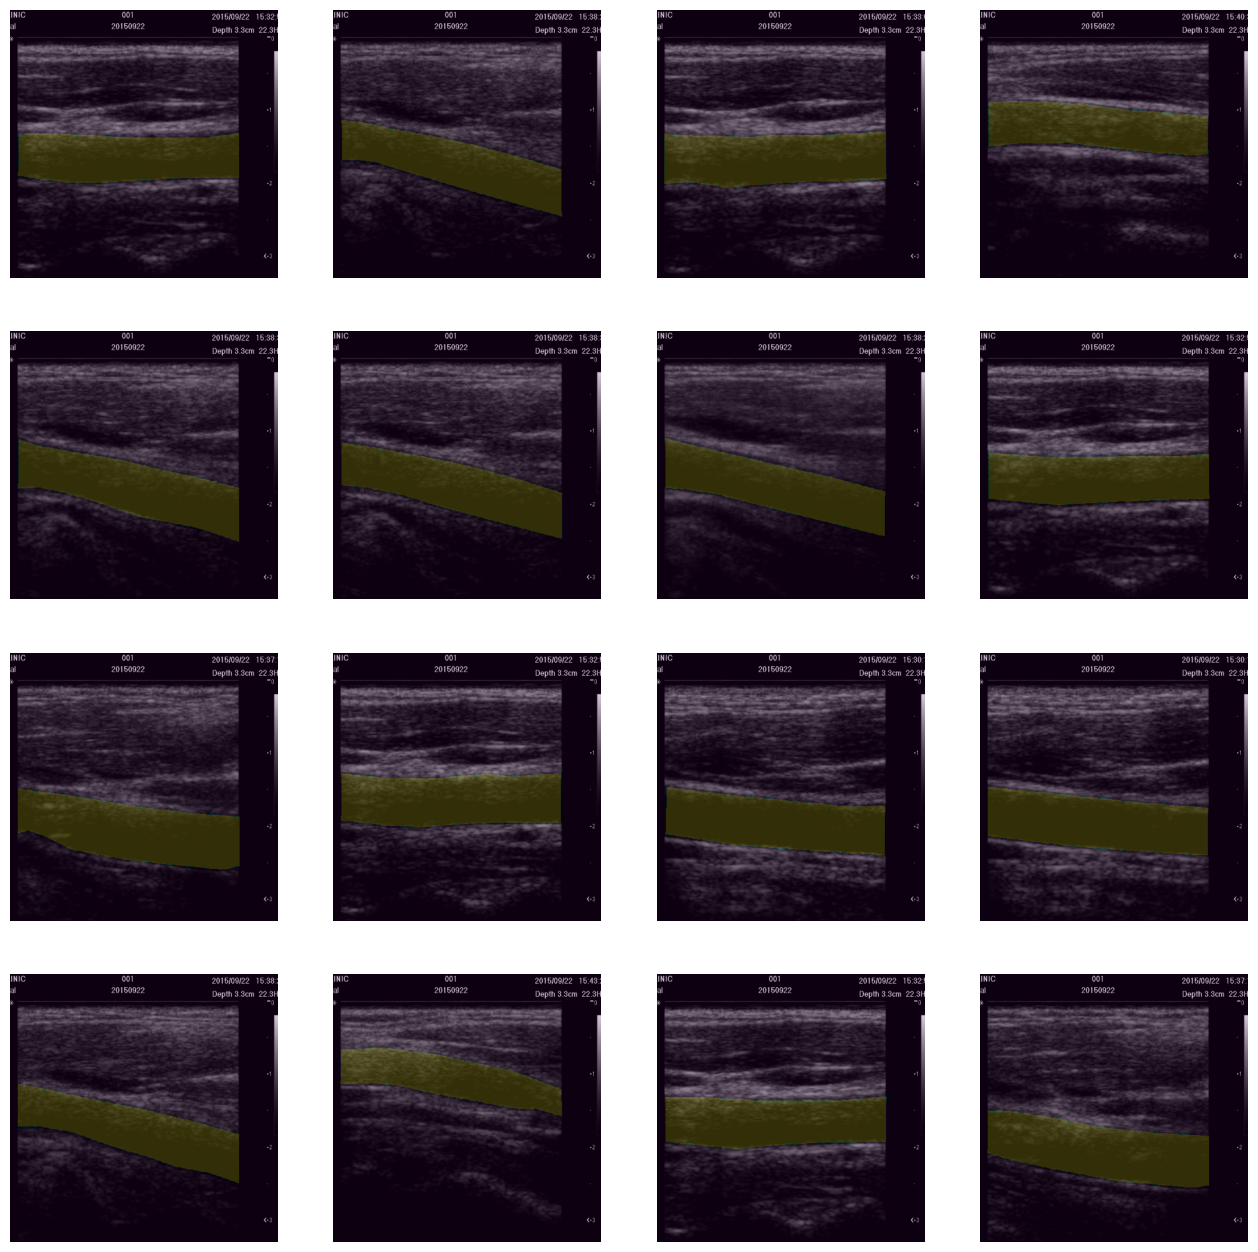

In [9]:
class config:
    
    input_size = (8, 3, 448, 448)
    mean = IMAGENET_DEFAULT_MEAN 
    std = IMAGENET_DEFAULT_STD

img_files = glob.glob("/kaggle/input/mia-hw4/sono/train/pre/*")
ds = DeepMedical(images=img_files, transforms=build_transform(True, config))
dl = torch.utils.data.DataLoader(ds,batch_size=16,shuffle=False,num_workers=0)

plt.figure(figsize=(16,16))
imgs,masks = next(iter(dl))

for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*torch.tensor(config.std) + torch.tensor(config.mean))*255.0).numpy().astype(np.uint8)
        
    plt.subplot(4,4,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
        
print(f"Image shape: {imgs.shape}, mask shape {mask.shape}")
    
del ds,dl,imgs,masks

In [10]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.block1_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.block1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.block1_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.block2_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.block2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.block2_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.block3_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.block3_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.block3_conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.block3_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.block4_conv1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.block4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block4_conv3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block4_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.block5_conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block5_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block5_conv3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block5_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.block5_predict = nn.Conv2d(512, 2, kernel_size=1, padding=0)
        self.block5_up = nn.ConvTranspose2d(2, 2, kernel_size=4, stride=4, bias=False)
        
        self.block4_predict = nn.Conv2d(512, 2, kernel_size=1, padding=0)
        self.block4_up = nn.ConvTranspose2d(2, 2, kernel_size=2, stride=2, bias=False)
        
        self.block3_predict = nn.Conv2d(256, 2, kernel_size=1, padding=0)
        
        self.total_upsample = nn.ConvTranspose2d(2, 2, kernel_size=8, stride=8, bias=False)

    def forward(self, x):
        block1 = self.block1_pool(self.block1_conv2(self.block1_conv1(x)))
        block2 = self.block2_pool(self.block2_conv2(self.block2_conv1(block1)))
        block3 = self.block3_pool(self.block3_conv3(self.block3_conv2(self.block3_conv1(block2))))
        block4 = self.block4_pool(self.block4_conv3(self.block4_conv2(self.block4_conv1(block3))))
        block5 = self.block5_pool(self.block5_conv3(self.block5_conv2(self.block5_conv1(block4))))
        
        transpose5 = self.block5_up(self.block5_predict(block5))
        transpose4 = self.block4_up(self.block4_predict(block4))
        transpose3 = self.block3_predict(block3)
        
        addition_upsample = transpose5+transpose4+transpose3
        output = self.total_upsample(addition_upsample)
        
        return output

In [11]:
class ConfusionMatrix(object):
    """
    update: use to update the confusion matrix in sample-wise
        a: ground truths
        b: predictions
    
    The (i, j) terms of the matrix represents class-i pixels classify to class-j
    """
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, a, b):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=a.device)
        with torch.no_grad():
            k = (a >= 0) & (a < n)
            inds = n * a[k].to(torch.int64) + b[k]
            self.mat += torch.bincount(inds, minlength=n**2).reshape(n, n)

    def reset(self):
        if self.mat is not None:
            self.mat.zero_()

    def compute(self):
        h = self.mat.float()
        correct = torch.diag(h)
        acc_global = correct.sum() / h.sum()
        acc = correct / h.sum(1)
        dice = 2 * correct  / (h.sum(1) + h.sum(0))
        iou = correct / (h.sum(1) + h.sum(0) - correct)
        
        self.acc_global = acc_global
        self.acc = acc
        self.iou = iou
        self.dice = dice
        
        return acc_global, acc, iou, dice

    def reduce_from_all_processes(self):
        if not torch.distributed.is_available():
            return
        if not torch.distributed.is_initialized():
            return
        torch.distributed.barrier()
        torch.distributed.all_reduce(self.mat)

    def __str__(self):
        acc_global, acc, iou, dice = self.compute()
        self.acc_global = acc_global
        self.miou = iou.mean().item() * 100
        self.dice = dice.mean().item() * 100
        return (
            'global correct: {:.2f}\n'
            'average row correct: {}\n'
            'IoU: {} mean IoU: {:.2f}\n'
            'dice: {} mean Dice: {:.2f}\n').format(
                acc_global.item() * 100,
                ['{:.1f}'.format(i) for i in (acc * 100).tolist()],
                ['{:.1f}'.format(i) for i in (iou * 100).tolist()],
                iou.mean().item() * 100,
                ['{:.2f}'.format(i) for i in (dice * 100).tolist()],
                dice.mean().item() * 100,
            )

class intersection_over_union:
    
    def __init__(self, y_true, y_pred):
    
        union = np.count_nonzero(y_true + y_pred)
        intersection = np.count_nonzero(y_true * y_pred)
        try:
            IoU = intersection / union
        except:
            IoU = 0
        self.IoU = IoU
        self.union = (y_true + y_pred != 0) * 1
        self.intersection = (y_true * y_pred != 0) * 1
        self.FP = (y_true == 0) * (y_pred == 1) * 1
        self.FN = (y_true == 1) * (y_pred == 0) * 1  

def visualization(model, valid_loader, args):
        
    for images, masks in valid_loader:
    
        images = images.to(device=args.device, dtype=torch.float)
        masks = masks.to(device=args.device, dtype=torch.long)

        logits = model(images)
        probs = torch.nn.functional.softmax(logits, dim=1)

        probs = probs[:,1,:,:]
        preds = (probs.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)

        threshold = 0.5

        binary_mask_threshold = (probs > threshold) * 1

        masks = (masks.permute(1,2,0) * 255).cpu().numpy().astype(np.uint8)
        images = ((images.squeeze(0).permute(1,2,0).cpu().detach().numpy()*np.array(args.std)+np.array(args.mean)) * 255).astype(np.uint8)
        probs = (probs.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)
        binary_mask_threshold = (binary_mask_threshold.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)

        iou = intersection_over_union(masks/255.0, binary_mask_threshold/255.0)
        IoU = iou.IoU
        intersection = iou.intersection
        union = iou.union
        FP = iou.FP
        FN = iou.FN

        fusion = np.concatenate([FP*255, intersection*255, FN*255], axis=2).astype(np.uint8)
        
        yield images, masks, probs, binary_mask_threshold, fusion, IoU

# Train

In [12]:
def train_one_epoch(model, train_loader, criterion, device, epoch, optimizer, print_freq=10, num_classes=2):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    
    confmat = ConfusionMatrix(num_classes)
    for images, masks in metric_logger.log_every(train_loader, print_freq, header):
        images = images.to(device=device, dtype=torch.float)
        masks = masks.to(device=device, dtype=torch.long)

        logits = model(images)
        loss = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
        confmat.update(masks.flatten(), logits.argmax(1).flatten())
        confmat.compute()
        
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(mIoU=torch.mean(confmat.iou[1:]))
        metric_logger.update(Dice=torch.mean(confmat.dice[1:]))
            
    confmat.reduce_from_all_processes()

@torch.no_grad()
def evaluate(model, data_loader, criterion, device, print_freq=10, num_classes=2, header=None):
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = header
    
    confmat = ConfusionMatrix(num_classes)
    for images, masks in metric_logger.log_every(data_loader, print_freq, header):
        images = images.to(device=device, dtype=torch.float)
        masks = masks.to(device=device, dtype=torch.long)
            
        logits = model(images)
        loss = criterion(logits, masks)

        confmat.update(masks.flatten(), logits.argmax(1).flatten())
        confmat.compute()
            
        metric_logger.update(loss=loss.item())
        metric_logger.update(mIoU=torch.mean(confmat.iou[1:]))
        metric_logger.update(Dice=torch.mean(confmat.dice[1:]))

    confmat.reduce_from_all_processes()

    return metric_logger, confmat

In [13]:
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [14]:
#try to set a more fitness parameters
def get_args():
    parser = argparse.ArgumentParser(description='SonoDataset Training')

    parser.add_argument('--root', type=str, default="/kaggle/input/mia-hw4/sono")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--weight_decay', type=float, default=2e-4)
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--lr', type=float, default=3e-4)
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--seed', type=int, default=42)

    parser.add_argument('--in_channels', type=int, default=3)
    parser.add_argument('--input_size', type=tuple, default=(4, 3, 224, 224)) #, 224, 224  32的倍數
    parser.add_argument('--target_size', type=tuple, default=(566, 640))
    parser.add_argument('--mean', type=list, default=IMAGENET_DEFAULT_MEAN)
    parser.add_argument('--std', type=list, default=IMAGENET_DEFAULT_STD)
    
    parser.add_argument('--project', type=str, default="MIA-HW4")
    parser.add_argument('--entity', type=str, default="DDCVLAB")
    parser.add_argument('--name', type=str, default="Unet")
    parser.add_argument('--wandb', type=bool, default=False) #True False
    parser.add_argument('--sweep', type=bool, default=True)
    parser.add_argument('--sweep_counts', type=int, default=8)
    
    parser.add_argument('--output_dir', type=str, default="")
    parser.add_argument('--data_path', type=str, default="/kaggle/input/mia-hw4/sono/train/pre/*")

    args, _ = parser.parse_known_args()
    return args

sweep_config = {
    "program": "main.py",
    "method": "random", # ["random", "grid", "bayes"]
    "metrics": {'goal': 'maximize', 'name': 'Validation Dice'},
    "parameters": {
        "lr": {
            "values": [6e-4, 3e-4, 1e-4, 8e-5]
        },
        "weight_decay": {
            "values": [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
        },
    }
}

In [15]:
# pip install wandb

/opt/conda/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pad". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


Training augmentation: Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
number of params (M): 31.04
model flops (G): 83.676708864 input_size: (4, 3, 224, 224)
LR = 0.00030000
WD = 0.00020000
Batch size = 16
Number of training epochs = 50
Number of training examples = 240
Number of training steps per epoch = 15
Use Cosine LR scheduler
criterion = CrossEntropyLoss()
Start Training
Epoch: [0]  [ 0/15]  eta: 0:00:23  lr: 0.000300  loss: 0.6628 (0.6628)  mIoU: 0.1025 (0.1025)  Dice: 0.1859 (0.1859)  time: 1.5476  data: 0.2954  max mem: 5279
Epoch: [0]  [10/15]  eta: 0:00:05  lr: 0.000300  loss: 0.2859 (0.4593)  mIoU: 0.3370 (0.2131)  Dice: 0.5041 (0.3460)  time: 1.0208  data: 0.3408  m

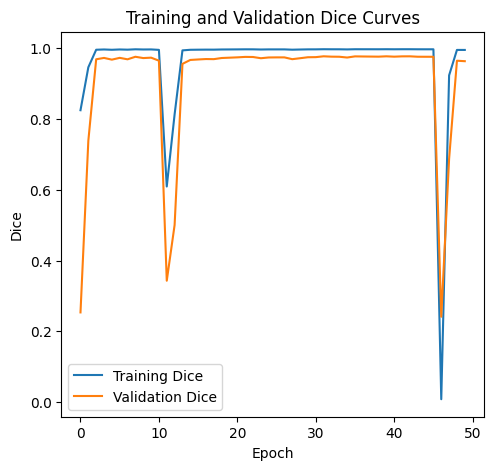

Finish


In [16]:
def sweeper(wandb_logger, args):
    
    if wandb_logger:
        wandb_logger.init_run()
        args = wandb_logger._wandb.config
    
    seed_everything(args.seed)
    
    img_files = glob.glob(args.data_path)
    
    train_ids, valid_ids = train_test_split(range(len(img_files)), test_size=0.2, random_state=args.seed)
    train_transform, valid_transform = build_transform(True, args), build_transform(False, args)
    train_dataset = DeepMedical(images=img_files, transforms=train_transform)
    valid_dataset = DeepMedical(images=img_files, transforms=valid_transform)
    train_dataset = SonoDataset(train_dataset, train_ids)
    valid_dataset = SonoDataset(valid_dataset, valid_ids)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1)

    model = UNet(n_channels=3,n_classes=2)
    model.to(args.device)
    if wandb_logger:
        wandb_logger._wandb.watch(model)

    params_to_optimize = [
        {"params": [p for p in model.parameters() if p.requires_grad]},
    ]

    optimizer = torch.optim.Adam(
        params_to_optimize,
        lr=args.lr, weight_decay=args.weight_decay
    )
    criterion = nn.CrossEntropyLoss()
        
    n_parameters = sum(p.numel() for p in params_to_optimize[0]["params"])
    macs = profile_macs(model, torch.randn(args.input_size).to(args.device))
    
    print("Training augmentation:", train_transform)
    print('number of params (M): %.2f' % (n_parameters / 1.e6))
    print('model flops (G):', macs / 2 / 1.e9, 'input_size:', args.input_size)
    print("LR = %.8f" % args.lr)
    print("WD = %.8f" % args.weight_decay)
    print("Batch size = %d" % args.batch_size)
    print("Number of training epochs = %d" % args.epochs)
    print("Number of training examples = %d" % len(train_dataset))
    print("Number of training steps per epoch = %d" % (len(train_dataset) // args.batch_size))
    print("Use Cosine LR scheduler")
    print("criterion = %s" % str(criterion))
    
    best_dice = 0
    start_time = time.time()
    print("Start Training")
    
    
    # recordings
    history = {
      "train": {
          "Dice": []
      },
      "valid": {
          "Dice": [],
          "Dice_train":[],
          "Dice_valid":[]
      },
    }
    
    for epoch in range(args.epochs):

        train_one_epoch(model, train_loader, criterion, args.device, epoch, optimizer)
        train_logger, train_confmat = evaluate(model, train_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(train_dataset), header="Eval [Train]")
        valid_logger, valid_confmat = evaluate(model, valid_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(valid_dataset), header="Eval [Valid]")
        

        history["valid"]["Dice_train"].append(valid_confmat.dice.cpu().numpy()[0] )
        history["valid"]["Dice_valid"].append(valid_confmat.dice.cpu().numpy()[1] )
        
        if wandb_logger:
            wandb_logger._wandb.log({f"Training Loss": getattr(train_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Training mIoU": getattr(train_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Training Dice": getattr(train_logger, "Dice", -1).value})

            wandb_logger._wandb.log({f"Validation Loss": getattr(valid_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Validation mIoU": getattr(valid_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Validation Dice": getattr(valid_logger, "Dice", -1).value})
        
        info = str(valid_confmat)
        print(info)

        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "args": wandb_logger.config if wandb_logger else {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}
        }
        if valid_confmat.dice > best_dice:
            best_dice = valid_confmat.dice
            torch.save(save_file, os.path.join(args.output_dir, "best_ckpt.pth"))
            if wandb_logger:
                wandb_logger._wandb.save("best_ckpt.pth")
        torch.save(save_file, os.path.join(args.output_dir, "last_ckpt.pth"))
        if wandb_logger:
            wandb_logger._wandb.save("last_ckpt.pth")
        
    if wandb_logger:
        wandb_logger._wandb.log({f"Best Dice": best_dice})
            
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("Training finish with time {}".format(total_time_str))
    
    if wandb_logger:
        print("Start logging images")
        iterator = visualization(model, valid_loader, args)
        for data in iterator:
            wandb_logger.log_image(*data)
        wandb_logger._wandb.log({"Image table": wandb_logger.mask_table})
       
    # history
#     train_Dice = history["train"]["Dice"]
#     valid_Dice = history["valid"]["Dice"]
    
    valid_Dice_0 = history["valid"]["Dice_train"]
    valid_Dice_1 = history["valid"]["Dice_valid"]
    
    
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(args.epochs), valid_Dice_0, label='Training Dice')
    plt.plot(np.arange(args.epochs), valid_Dice_1, label='Validation Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.title('Training and Validation Dice Curves')
    plt.show()
    
    print("Finish")

if __name__ == '__main__':
    
    # print_with_timestamp()
    
    args = get_args()
    config = {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}
    
    if args.wandb:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()

        WANDB_API = user_secrets.get_secret("wandb-api")
        wandb_logger = WandbLogger(config)
        wandb_logger.login(WANDB_API)

    
        if args.sweep:
            sweep_id = wandb.sweep(sweep_config, project=args.project)
            wandb.agent(sweep_id, function=lambda: sweeper(wandb_logger, args), count=args.sweep_counts)
        else:
            sweeper(wandb_logger, args)
    else:
        sweeper(None, args)


# Inference

In [17]:
import pandas as pd

class SonoInferenceDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, df, transforms=None):
        
        self.root = root
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        
        image_path = os.path.join(self.root, "test", "pre", self.df.iloc[idx,0])
        
        image = np.array(Image.open(image_path).convert('RGB'))

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']
            
        return image

@torch.no_grad()
def inference(model, data_loader, args):
    model.eval()
    
    rle = []
    for images in tqdm(data_loader):
        images = images.to(device=args.device, dtype=torch.float)
            
        logits = model(images)
        masks = logits.argmax(dim=1).detach().cpu().numpy()
        for batch, mask in enumerate(masks):
            mask = Image.fromarray((mask*255).astype(np.uint8)).resize((args.target_size[1], args.target_size[0]))
            rle.append(rle_encode(np.array(mask), fg_val=255))
    return rle

In [18]:
args = get_args()
sample_submission = pd.read_csv(os.path.join(args.root, "sample_submission.csv"))
test_dataset = SonoInferenceDataset(args.root, sample_submission, build_transform(False, args))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.device)
#state_dict = torch.load(os.path.join(args.output_dir, "last_ckpt.pth"), map_location=args.device)
model = UNet(n_channels=3,n_classes=2)
model.to(args.device)
model.load_state_dict(state_dict["model"])

rle = inference(model, test_loader, args)
sample_submission["rle_encode"] = [list_to_string(r) for r in rle]
sample_submission.to_csv("submission.csv", index=0)

100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


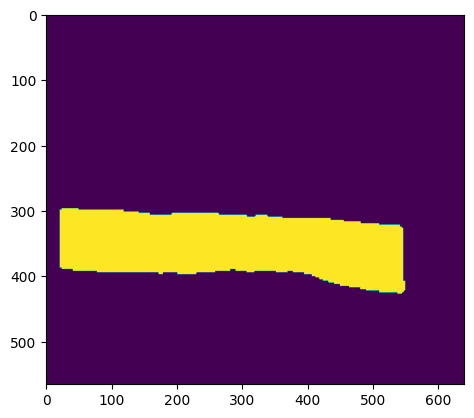

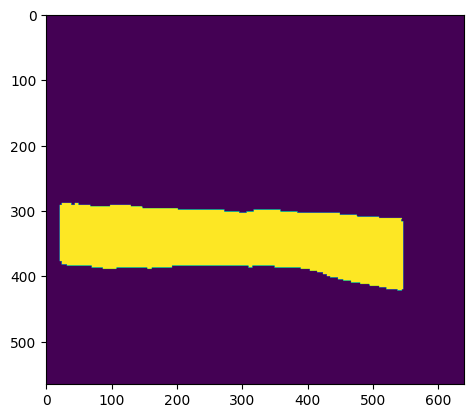

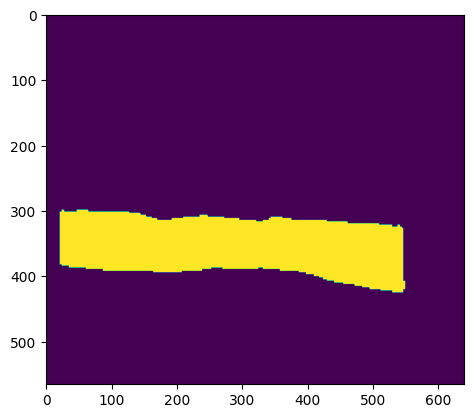

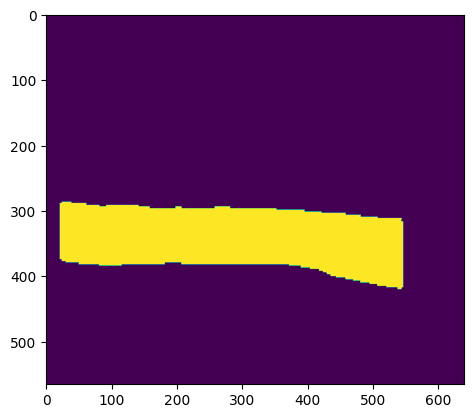

In [19]:
for i in range(4):
    plt.imshow(rle_decode(list_to_string(rle[i])))
    plt.show()